Start of n=8
Runtime:  0.07583093643188477 seconds
Start of n=16
Runtime:  0.277817964553833 seconds
Start of n=32
Runtime:  0.9815487861633301 seconds
Start of n=64
Runtime:  3.750108003616333 seconds
Start of n=128
Runtime:  18.87317705154419 seconds


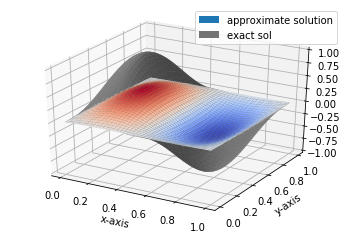

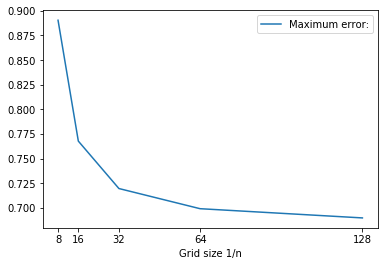

In [2]:
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.sparse.linalg as LA 
import scipy

def solution(x,y): #the analytic solution of the equation
    return np.sin(2*x*math.pi)*np.sin(y*math.pi)

def func(x,y): #the function in the problem
    return 5*math.pi*np.sin(2*x*math.pi)*np.sin(y*math.pi)

def A_matrix(n):
    """
    Input:
        n: The dimensions of I and L where as I is the identity, L is the Matrix of the poisson equation
    Output:
        A: LxI+IxL where x is the kronecker product, a sparse matrix in the csr forma
    """
    data=[[-1 for i in range(n-1)], [2 for i in range(n-1)], [-1 for i in range(n-1)]]
    diags=[-1,0,1]
    
    L=n**2*scipy.sparse.spdiags(data, diags, n-1, n-1, format= 'csr')#.toarray()
    I=scipy.sparse.eye(n-1, dtype=np.int8, format= 'csr')#.toarray()

    A=(scipy.sparse.kron(L,I)+scipy.sparse.kron(I,L))#.toarray()

    return A


def jacobi_iteration(A, u_0, b, eps, n):
    """
    Input:
        A:   The cronecker product of A and I, a (n-1)^2 x (n-1)^2 sparse matrix
        u_0: The starting vector of the algorithm, a (n-1)^2 sparse matrix
        b:   The values of the laplace, a (n-1)^2 sparse array
        eps: The stopping criterium
        n: the dimension
    Output:
        An approximate solution x to Ax=b via the Jacobi method 
        
    """
    diag_param=4*n**2#all diagonal entries of A are the same, diagonal matrix only multiplies entries
    
    u_1= u_0 +1/(diag_param)*(b-A*u_0)
#    counter=0
    while LA.norm((u_0-u_1)) >= eps: #.transpose()
        start=time.time()
        u_0= u_1
        u_1= u_0 +(1/diag_param)*(b-A*u_0)
#        print(time.time()-start)
#        counter+=1
#    print(counter)
#    print(scipy.sparse.linalg.spsolve(A,b))
    return u_1

#Ich habe hier den param gegen A[0][0] getestet und keine signifikanten Unterschied bemerkt, sollte für großes n etwas schneller sein

def test_discretization_param(n):
    """
    Input:
        n an integer
    Output:
        the approximate solution of the Poisson problem on (0,1)x(0,1) with grid size 1/n
    """
    
    eps=1e-5
    
    u_0=scipy.sparse.csr_matrix.transpose(scipy.sparse.csr_matrix([0 for i in range((n-1)**2)]))
    b=[]
    for j in range(1,n): #produce the b array for the jacobi iteration according to the sheet
        b_add=[func(i/n,j/n) for i in range(n-1)]
        b+=b_add
    b=scipy.sparse.csr_matrix.transpose(scipy.sparse.csr_matrix(b))
    A=A_matrix(n)
#    start=time.time()
    res = jacobi_iteration(A, u_0, b, eps,n)
#    print("Runtime Jacobi=: ",time.time()-start, "seconds")
    return res

test_array=[8,16,32,64,128] 
error_arr=[]
for i in test_array:
    print("Start of n="+str(i))
    start=time.time()
    B=test_discretization_param(i)
    print("Runtime: ",time.time()-start, "seconds")
    C= np.reshape(B,(i-1,i-1)).toarray()#transponieren oder nicht?!
    
    X=[j/i for j in range(1,i)]
    Y=X
    X,Y= np.meshgrid(X,Y)
    
    if i==128: 
        fig=plt.figure()#the 3D visualization of the approximate solution
        ax=fig.gca(projection='3d')
               
        c1 = ax.plot_surface(X,Y,C,label="approximate solution", cmap=cm.coolwarm)
        c1._facecolors2d=c1._facecolors3d
        c1._edgecolors2d=c1._edgecolors3d

        c2= ax.plot_surface(X,Y,solution(X,Y), label="exact sol", color = "grey")
        c2._facecolors2d=c2._facecolors3d
        c2._edgecolors2d=c2._edgecolors3d
        
        ax.set_ylabel("y-axis")
        ax.set_xlabel("x-axis")
        handles, labels = ax.get_legend_handles_labels()
        idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
        ax.legend(np.array(handles)[idx], np.array(labels)[idx])
        
        plt.show()

    error_arr.append(np.linalg.norm(np.ravel(solution(X,Y)-C),np.inf))  
    
plt.plot(test_array,error_arr, label="Maximum error:")
plt.xticks(test_array)
plt.xlabel("Grid size 1/n")
plt.legend()
plt.show()
    